In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
smartphone_review = pd.read_csv('smartphone.csv', encoding = 'utf-8-sig')

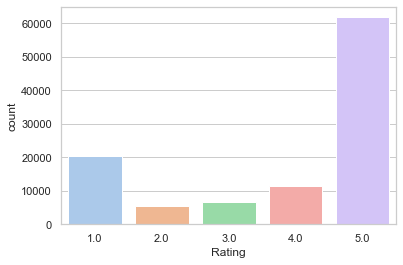

In [4]:
# 그래프 테마 설정
sns.set_theme(style="whitegrid", palette="pastel")
# 점수 분포
sns.countplot(data=smartphone_review, x="Rating")
plt.show()

In [5]:
df_clean = smartphone_review.dropna(subset = ['Body']).copy()

In [6]:
# 점수 분포에서 5점이 압도적으로 많기 때문에, 5점을 positive, 4점 이하를 negative로 둠
df_clean['Label'] = df_clean['Rating'] == 5

In [7]:
df_clean.head()

,Product_nm,Rating,Title,Body,Product_cd,Brand,Label
0,삼성 갤럭시 S21 플러스 5G SM-G996B/DS 256GB 8GB RAM 인터...,5.0,Esta hermoso pero no fue compatible con mi ope...,Esta hermoso pero no fue compatible con mi ope...,B08QXW1TXX,Samsung,True
1,삼성 갤럭시 S21 플러스 5G SM-G996B/DS 256GB 8GB RAM 인터...,1.0,FALSE ADVERTISEMENT,"The phone was advertised as....""This phone wil...",B08QXW1TXX,Samsung,False
2,삼성 갤럭시 S21 플러스 5G SM-G996B/DS 256GB 8GB RAM 인터...,4.0,"""B"" version - not compatible with AT&T",Did not have a chance to use it. Not working w...,B08QXW1TXX,Samsung,False
3,삼성 갤럭시 S21 플러스 5G SM-G996B/DS 256GB 8GB RAM 인터...,5.0,"So happy with the phone, as good as I expected...","I bought this for my girl, an she is so happy ...",B08QXW1TXX,Samsung,True
4,삼성 갤럭시 S21 플러스 5G SM-G996B/DS 256GB 8GB RAM 인터...,1.0,"This ""International"" Version is not covered by...","After 5 months, the defective screen just stop...",B08QXW1TXX,Samsung,False


# 텍스트 전처리

In [8]:
import spacy
from collections import Counter
import math
from tqdm import tqdm

In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
tokens_normalized = []
for doc in tqdm(nlp.pipe(df_clean['Body'].str.lower())):
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    tokens_normalized.append(lemmas)

105535it [05:59, 293.21it/s]


**Phrase modeling (bigram & trigram)**

In [11]:
from gensim.models.phrases import Phrases, Phraser

C:\Users\82109\anaconda3\envs\pytorch\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
bigram_model = Phrases(tokens_normalized)
bigram_phraser = Phraser(bigram_model)

In [13]:
tokens_bigram = []
for s in tokens_normalized:
    bigram_phrases = bigram_phraser[s]
    tokens_bigram.append(bigram_phrases)

In [14]:
trigram_model = Phrases(tokens_bigram)
trigram_phraser = Phraser(trigram_model)

In [15]:
tokens_trigram = []
for s in tokens_bigram:
    trigram_phrases = trigram_phraser[s]
    trigram_phrases = [token for token in trigram_phrases if token not in nlp.Defaults.stop_words and token != '-PRON-']
    tokens_trigram.append(trigram_phrases)

In [16]:
preprocessed_sentences = []
for s in tokens_trigram:
    preprocessed_sentences.append(' '.join(s))

In [17]:
df_clean['Reviews Preprocessed'] = preprocessed_sentences

In [18]:
# 학습용과 테스트용 데이터 나누기
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_clean, random_state=0)

In [19]:
def preprocess_text(text):
    text = text.lower()
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    bigrams = bigram_phraser[lemmas]
    trigrams = trigram_phraser[bigrams]
    tokens_normalized = [lemma for lemma in trigrams if lemma not in nlp.Defaults.stop_words and lemma != '-PRON-']
    return tokens_normalized

## 로지스틱 회귀 감성분석

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [21]:
# 사전(vocabulary) 학습
# document-term matrix를 만드는 데 사용됨
vect.fit(df_train['Reviews Preprocessed'])
X_train_dtm = vect.transform(df_train['Reviews Preprocessed'])

In [22]:
# 테스트 데이터를 document-term matrix로 바꾸기 (학습된 사전 활용)
X_test_dtm = vect.transform(df_test['Reviews Preprocessed'])
X_test_dtm

<26384x36536 sparse matrix of type '<class 'numpy.int64'>'
	with 368282 stored elements in Compressed Sparse Row format>

In [23]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)

In [24]:
logreg.fit(X_train_dtm, df_train['Label'])

LogisticRegression(max_iter=1000)

In [25]:
# X_test_dtm에 대해 클래스 예측
y_pred_class = logreg.predict(X_test_dtm)

In [26]:
# X_test_dtm에 대해 확률 예측
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.90505277, 0.66278674, 0.86742473, ..., 0.01877788, 0.00317317,
       0.36554134])

In [27]:
print(df_test['Body'].iloc[0])
print()
print(y_pred_prob[0])

Best and fast delivery Thank you.

0.9050527731552587


In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [29]:
# 클래스 예측 정확도 : 약 83.6%
accuracy_score(df_test['Label'], y_pred_class)

0.8360369921164342